In [1]:
import pandas as pd
import numpy as np
import os
from structlog import get_logger
import matplotlib.pyplot as plt


logger = get_logger()

# Load Dataset

In [2]:
df_train = pd.read_csv('/home/fraverta/development/comp642-project/trading_the_close_data/train.csv')

# sort the data by stock_id, date_id, seconds_in_bucket
df_train = df_train.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket'])

# sort the data by stock_id, date_id, seconds_in_bucket
df_train = df_train.sort_values(by=['date_id', 'seconds_in_bucket', 'stock_id'])




In [3]:
df_train.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')

In [4]:
days_to_filter = set()
for (date_id, seconds_in_bucket), stock_ids in df_train.groupby(['date_id', 'seconds_in_bucket'])['stock_id']:
    if len(stock_ids) != 200:
        days_to_filter.add(date_id)   

# remove days with less than 200 stock_ids
df_train = df_train[~df_train['date_id'].isin(days_to_filter)]
df_train.groupby(['date_id', 'seconds_in_bucket']).size().value_counts()

200    10175
dtype: int64

In [5]:
len(df_train)

2035000

In [6]:
# split the data into train and validation
train = df_train[df_train['date_id'] < 425]
valid = df_train[df_train['date_id'] >= 425]

# check the number of unique stock_ids in the train and validation set
#len(train['stock_id'].unique()), len(valid['stock_id'].unique())        

len(train), len(valid)


(1419000, 616000)

# stocks         : 200
# dates          : 129
# updates per day: 55


100%|██████████| 25800/25800 [00:15<00:00, 1658.59it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Fit >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Coef: [0.00400074 0.00100044 0.00200015 0.00599848 0.00399866 0.00399937
 0.00200174 0.00599935 0.00600054 0.00199879 0.00200236 0.00799943
 0.00599979 0.00199903 0.00800089 0.00600052 0.00199874 0.00599966
 0.00400085 0.00199956 0.00399816 0.00100056 0.00599935 0.00399939
 0.00199918 0.00200017 0.0039988  0.00200064 0.00400012 0.00399996
 0.00100044 0.00099983 0.00199965 0.00199924 0.00599894 0.00400114
 0.00399979 0.0039994  0.00600062 0.0020004  0.00200079 0.03999917
 0.00200047 0.00199936 0.00399975 0.04000155 0.00199997 0.00100047
 0.0060002  0.00400139 0.00399893 0.0060001  0.00100005 0.00400012
 0.00400014 0.00199841 0.00599991 0.00400031 0.00599947 0.00400025
 0.0059994  0.00400005 0.00200001 0.00100024 0.00199936 0.00400006
 0.00199956 0.0080008  0.00400102 0.00399991 0.00199969 0.00399909
 0.00600143 0.00199952 0.00399932 0.00400131 0.0020001  0.00400126
 0.00400052 0.00399918 0.0010006  0.001999

100%|██████████| 11200/11200 [00:07<00:00, 1580.35it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Fit >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Coef: [0.00399949 0.00099972 0.00200074 0.00599591 0.00400052 0.00400119
 0.0020004  0.00599699 0.00600247 0.00199905 0.00199907 0.0079998
 0.0059967  0.00199917 0.00800387 0.00599951 0.00200017 0.00599972
 0.00400035 0.00199877 0.00399829 0.0009984  0.00599985 0.00399753
 0.00199446 0.00200146 0.00400158 0.00200016 0.00399978 0.00399886
 0.00099737 0.001      0.00199883 0.00199967 0.00600083 0.00399899
 0.00399982 0.00400238 0.00600219 0.00200056 0.00200039 0.0399985
 0.00199925 0.00199894 0.00399883 0.04000084 0.00199924 0.0010003
 0.00600019 0.00399633 0.00400103 0.00600115 0.00099976 0.00400426
 0.00399809 0.00199829 0.00600023 0.00400163 0.00599739 0.0040005
 0.00600434 0.00399979 0.00200048 0.00100135 0.00199998 0.00400168
 0.00199812 0.00800041 0.00399838 0.00400016 0.00199897 0.00399995
 0.00599854 0.00200044 0.00399881 0.00400031 0.00199954 0.00400322
 0.00399874 0.00399959 0.00100083 0.00199709 0

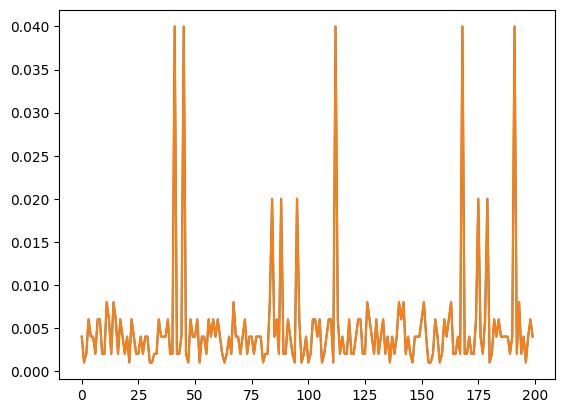

In [7]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm
import polars as pl


def get_stock_index_coeficient(df):
    num_stocks = df["stock_id"].nunique()
    num_dates = df["date_id"].nunique()
    num_updates = df["seconds_in_bucket"].nunique()

    num_dates_map = {v:i for i, v in enumerate(sorted(df["date_id"].unique()))}

    print(f"# stocks         : {num_stocks}")
    print(f"# dates          : {num_dates}")
    print(f"# updates per day: {num_updates}")

    stock_returns = np.zeros((num_stocks, num_dates, num_updates))
    index_returns = np.zeros((num_stocks, num_dates, num_updates))


    for (stock_id, date_id), frame in tqdm(df.groupby(["stock_id", "date_id"])):
        frame["stock_return"] = ((frame["wap"] / frame["wap"].shift(6)).shift(-6) - 1) * 10_000
        frame["index_return"] = frame["stock_return"] - frame["target"]

        stock_returns[stock_id, num_dates_map[date_id]] = frame["stock_return"].values
        index_returns[stock_id, num_dates_map[date_id]] = frame["index_return"].values

    index_return = np.mean(index_returns, axis=0)

    lr = LinearRegression()
    y = index_return.reshape(-1)
    X = stock_returns.reshape((num_stocks, -1)).T

    mask = ~((np.isnan(y) | np.isnan(X).any(axis=1)))
    X, y = X[mask], y[mask]

    lr.fit(X, y)

    print(" Fit ".center(80, ">"))
    print("Coef:", lr.coef_)
    print("Intercept:", lr.intercept_)
    print("R2:", r2_score(y, lr.predict(X)))

    lr.coef_ = lr.coef_.round(3)
    lr.intercept_ = 0.0
    print(" Round with 3 digits ".center(80, ">"))
    print("Coef:", lr.coef_)
    print("Sum of Coef:", lr.coef_.sum())
    print("R2:", r2_score(y, lr.predict(X)))
    return lr.coef_

coef_train = get_stock_index_coeficient(train)
coef_validation = get_stock_index_coeficient(valid)


plt.plot(coef_train, label="train")
plt.plot(coef_validation, label="train")


In [8]:
sum(abs(coef_train - coef_validation))


0.0

# Check if we can know the weights for the index

In [9]:
WEIGHTS = [0.004,0.00099987, 0.00200041, 0.00599891, 0.00400068, 0.00399949,
0.00200014, 0.0059992 , 0.00600029, 0.00200012, 0.00200072, 0.00800012,
0.00600039, 0.00200007, 0.0080014 , 0.00600051, 0.00199993, 0.0059999,
0.00400013, 0.00199974, 0.00399933, 0.00099993, 0.00599955, 0.00399971,
0.00199876, 0.00200008, 0.00400097, 0.0020008 , 0.00400021, 0.00400005,
0.00100001, 0.00100016, 0.00199924, 0.00199993, 0.00599995, 0.00399917,
0.00400017, 0.00399906, 0.00599977, 0.00200015, 0.0020007 , 0.03999955,
0.0020001 , 0.00199981, 0.00399968, 0.03999983, 0.00200033, 0.00099959,
0.00600002, 0.00399944, 0.00399979, 0.00600017, 0.00099921, 0.00399993,
0.00399936, 0.0019985 , 0.00599995, 0.00400028, 0.00599981, 0.00400045,
0.00600029, 0.00399988, 0.00200012, 0.00100003, 0.00200041, 0.00400043,
0.00200011, 0.00799989, 0.00400056, 0.00400011, 0.00199956, 0.00399921,
0.00599994, 0.00199992, 0.00399979, 0.00400047, 0.00200035, 0.00399996,
0.00400003, 0.00399989, 0.00100029, 0.00199997, 0.00200019, 0.00799969,
0.02000066, 0.00400029, 0.00600019, 0.00200024, 0.02      , 0.00199965,
0.00199968, 0.00599962, 0.00399987, 0.00199997, 0.00099953, 0.02000033,
0.00600029, 0.00099946, 0.00200062, 0.00399946, 0.00100021, 0.00199986,
0.00600047, 0.00600071, 0.00399889, 0.00600028, 0.0010003 , 0.00199986,
0.00400008, 0.00600071, 0.00600016, 0.00100013, 0.04000011, 0.00599947,
0.00200012, 0.00400061, 0.00199956, 0.00199961, 0.00599985, 0.00200055,
0.00200083, 0.00399993, 0.00599961, 0.00600028, 0.00200005, 0.00199999,
0.0080003 , 0.00600021, 0.00400044, 0.00199994, 0.00599988, 0.00200002,
0.00399908, 0.00600099, 0.00200021, 0.00399981, 0.00100042, 0.00399994,
0.00199993, 0.0039995 , 0.00800063, 0.00600055, 0.00799953, 0.00200005,
0.00400064, 0.00199988, 0.00099981, 0.00399912, 0.00399992, 0.00399974,
0.00599995, 0.00800022, 0.00400055, 0.00099968, 0.00099956, 0.00200017,
0.00599973, 0.00400059, 0.00100004, 0.00199961, 0.00599971, 0.00400006,
0.00599987, 0.00800007, 0.00200054, 0.00200102, 0.00400114, 0.00199923,
0.0399987 , 0.00199969, 0.00199982, 0.00399976, 0.00199995, 0.00200001,
0.00599982, 0.02000055, 0.0039996 , 0.00200022, 0.00600002, 0.01999984,
0.00100015, 0.00200021, 0.0059996 , 0.00400055, 0.00599988, 0.00400022,
0.00399931, 0.0040002 , 0.0039998 , 0.002     , 0.00399975, 0.04000041,
0.00200037, 0.00799998, 0.00199977, 0.00400093, 0.00099996, 0.00400022,
0.00599947, 0.00400014]

In [10]:

from tqdm import tqdm

def compute_index(df):
    index_values = {'date_id': [], "seconds_in_bucket":[], 'index_wap': []}
    for (date, seconds_in_bucket), records  in tqdm(df.groupby(['date_id', 'seconds_in_bucket'])):
        index_values['date_id'].append(date)
        index_values['seconds_in_bucket'].append(seconds_in_bucket)
        index_values['index_wap'].append(sum(records['wap'] * records['weights']))
        
    return pd.DataFrame(index_values)

# add a weights column to the dataframe, where for the column stock_id, the weights are the weights WEIGHTS[stock_id]
train["weights"] = train["stock_id"].apply(lambda x: coef_train[x])
index_computed = compute_index(train)
index_computed.to_csv('/home/fraverta/development/comp642-project/trading_the_close_data/train_index_wap2.csv', index=False)
index_computed.head()
        

/tmp/ipykernel_193724/2961799342.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["weights"] = train["stock_id"].apply(lambda x: coef_train[x])
100%|██████████| 7095/7095 [00:00<00:00, 7881.80it/s]


,date_id,seconds_in_bucket,index_wap
0,295,0,1.000000
1,295,10,0.999863
2,295,20,1.000633
3,295,30,1.000754
4,295,40,1.000427


In [11]:
# join df and df2 on date_id and seconds_in_bucket
df_train3 = train.merge(index_computed, on=['date_id', 'seconds_in_bucket'], how='left')
df_train3 = df_train3.sort_values(by=["stock_id", "date_id", "seconds_in_bucket"])
df_train3["wap_t+60"] = df_train3.groupby(["stock_id", "date_id"])["wap"].shift(-6)
df_train3["index_wap_t+60"] = df_train3.groupby(["stock_id", "date_id"])["index_wap"].shift(-6)
df_train3["predicted_target"] = ((df_train3["wap_t+60"] / df_train3["wap"]) - (df_train3["index_wap_t+60"] / df_train3["index_wap"])) * 10000
df_train3.to_csv('/home/fraverta/development/comp642-project/trading_the_close_data/train_index_wap_predicted_target2.csv', index=False)


#df3 such that predicted_target is not nan
df_train3 = df_train3[~df_train3["predicted_target"].isna()]
df_train3

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,ask_size,wap,target,time_id,row_id,weights,index_wap,wap_t+60,index_wap_t+60,predicted_target
0,0,295,0,9367721.39,-1,1.000586,15746692.71,NaN,NaN,0.999710,...,54834.00,1.000000,7.699728,16225,295_0_0,0.004,1.000000,1.000903,1.000133,7.698240
200,0,295,10,9365894.86,-1,1.001024,15767241.17,NaN,NaN,1.001024,...,41148.00,1.001139,-3.510117,16226,295_10_0,0.004,0.999863,1.001230,1.000305,-3.507318
400,0,295,20,9338496.92,-1,1.001243,15794639.11,NaN,NaN,1.001243,...,9145.00,1.001244,3.000498,16227,295_20_0,0.004,1.000633,1.001484,1.000572,3.000976
600,0,295,30,9755493.59,-1,1.001353,15794639.11,NaN,NaN,1.001353,...,18292.00,1.001394,1.169443,16228,295_30_0,0.004,1.000754,1.001463,1.000706,1.173994
800,0,295,40,9736771.66,-1,1.000915,15794639.11,NaN,NaN,1.000805,...,18284.00,1.000987,1.549721,16229,295_40_0,0.004,1.000427,1.001372,1.000657,1.545206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1416999,199,424,440,417468.63,-1,0.999504,12998593.16,0.995399,0.997794,0.999504,...,196600.98,0.999613,3.989935,23364,424_440_199,0.004,0.999432,0.999984,0.999403,3.995618
1417199,199,424,450,417468.63,-1,0.999504,12998593.16,0.995399,0.997794,0.999504,...,202446.98,0.999608,-0.429750,23365,424_450_199,0.004,0.999291,0.999576,0.999302,-0.428943
1417399,199,424,460,14032.56,-1,0.999504,13402029.23,0.999162,0.999504,0.999504,...,156234.35,0.999625,-1.490116,23366,424_460_199,0.004,0.999237,0.999590,0.999350,-1.486238
1417599,199,424,470,0.00,0,0.999504,13416061.79,0.999504,0.999504,0.999504,...,182541.35,0.999602,-1.260042,23367,424_470_199,0.004,0.999208,0.999594,0.999326,-1.267172


In [12]:

df_train3["error"] = df_train3["target"].round(2) - df_train3["predicted_target"].round(2)
df_train3[["target", "predicted_target", "error"]].head(100)
# sum not nan
sum(abs(df_train3[~df_train3["error"].isna()]["error"])) / len(df_train3)

0.00400757673152695

In [13]:
df_train3

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,wap,target,time_id,row_id,weights,index_wap,wap_t+60,index_wap_t+60,predicted_target,error
0,0,295,0,9367721.39,-1,1.000586,15746692.71,NaN,NaN,0.999710,...,1.000000,7.699728,16225,295_0_0,0.004,1.000000,1.000903,1.000133,7.698240,0.00
200,0,295,10,9365894.86,-1,1.001024,15767241.17,NaN,NaN,1.001024,...,1.001139,-3.510117,16226,295_10_0,0.004,0.999863,1.001230,1.000305,-3.507318,0.00
400,0,295,20,9338496.92,-1,1.001243,15794639.11,NaN,NaN,1.001243,...,1.001244,3.000498,16227,295_20_0,0.004,1.000633,1.001484,1.000572,3.000976,0.00
600,0,295,30,9755493.59,-1,1.001353,15794639.11,NaN,NaN,1.001353,...,1.001394,1.169443,16228,295_30_0,0.004,1.000754,1.001463,1.000706,1.173994,0.00
800,0,295,40,9736771.66,-1,1.000915,15794639.11,NaN,NaN,1.000805,...,1.000987,1.549721,16229,295_40_0,0.004,1.000427,1.001372,1.000657,1.545206,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1416999,199,424,440,417468.63,-1,0.999504,12998593.16,0.995399,0.997794,0.999504,...,0.999613,3.989935,23364,424_440_199,0.004,0.999432,0.999984,0.999403,3.995618,-0.01
1417199,199,424,450,417468.63,-1,0.999504,12998593.16,0.995399,0.997794,0.999504,...,0.999608,-0.429750,23365,424_450_199,0.004,0.999291,0.999576,0.999302,-0.428943,0.00
1417399,199,424,460,14032.56,-1,0.999504,13402029.23,0.999162,0.999504,0.999504,...,0.999625,-1.490116,23366,424_460_199,0.004,0.999237,0.999590,0.999350,-1.486238,0.00
1417599,199,424,470,0.00,0,0.999504,13416061.79,0.999504,0.999504,0.999504,...,0.999602,-1.260042,23367,424_470_199,0.004,0.999208,0.999594,0.999326,-1.267172,0.01


In [14]:
valid["weights"] = valid["stock_id"].apply(lambda x: coef_train[x])
index_computed = compute_index(valid)
valid = valid.merge(index_computed, on=['date_id', 'seconds_in_bucket'], how='left')

valid = valid.sort_values(by=["stock_id", "date_id", "seconds_in_bucket"])
valid["wap_t+60"] = valid.groupby(["stock_id", "date_id"])["wap"].shift(-6)
valid["index_wap_t+60"] = valid.groupby(["stock_id", "date_id"])["index_wap"].shift(-6)
valid["predicted_target"] = ((valid["wap_t+60"] / valid["wap"]) - (valid["index_wap_t+60"] / valid["index_wap"])) * 10000
valid["error"] = valid["target"].round(2) - valid["predicted_target"].round(2)
valid[["target", "predicted_target", "error"]].head(100)
# sum not nan
sum(abs(valid[~valid["error"].isna()]["error"])) / len(valid)


/tmp/ipykernel_193724/2891441969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["weights"] = valid["stock_id"].apply(lambda x: coef_train[x])
100%|██████████| 3080/3080 [00:00<00:00, 8091.95it/s]


0.003580292207794457

# Prophet Model

/tmp/ipykernel_193724/2619873196.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ds"] =  start_date + pd.to_timedelta(df["date_id"], unit='D') + pd.to_timedelta(df["seconds_in_bucket"], unit='S')
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/home/fraverta/development/ML/venv/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


                         ds       y
1417600 2022-03-01 16:58:00  1.0007
ds    datetime64[ns]
y            float64
dtype: object
Initial log joint probability = -2.02627
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       38352.2   0.000287737       17515.9       1.641      0.1641      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       38429.5    3.5034e-05       72106.7      0.1195           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       38470.3   0.000283493       84824.8           1           1      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       38518.9    0.00133063       36546.7           1           1      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       38571.4 

/home/fraverta/development/ML/venv/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/fraverta/development/ML/venv/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/fraverta/development/ML/venv/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/fraverta/development/ML/venv/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
6223,2022-03-02 16:58:00,0.996123,0.998375,1.001493,0.996123,0.996123,0.003756,0.003756,0.003756,0.003719,0.003719,0.003719,0.000038,0.000038,0.000038,0.0,0.0,0.0,0.999879
6224,2022-03-03 16:58:00,0.996119,0.998317,1.001553,0.996016,0.996270,0.003706,0.003706,0.003706,0.003719,0.003719,0.003719,-0.000013,-0.000013,-0.000013,0.0,0.0,0.0,0.999825
6225,2022-03-04 16:58:00,0.996115,0.998330,1.001728,0.995819,0.996491,0.003937,0.003937,0.003937,0.003719,0.003719,0.003719,0.000218,0.000218,0.000218,0.0,0.0,0.0,1.000052
6226,2022-03-05 16:58:00,0.996112,0.998513,1.001975,0.995520,0.996813,0.004144,0.004144,0.004144,0.003719,0.003719,0.003719,0.000425,0.000425,0.000425,0.0,0.0,0.0,1.000256
6227,2022-03-06 16:58:00,0.996108,0.997775,1.001832,0.995198,0.997172,0.003634,0.003634,0.003634,0.003719,0.003719,0.003719,-0.000084,-0.000084,-0.000084,0.0,0.0,0.0,0.999742
6228,2022-03-07 16:58:00,0.996104,0.997625,1.002023,0.994831,0.997583,0.003625,0.003625,0.003625,0.003719,0.003719,0.003719,-0.000094,-0.000094,-0.000094,0.0,0.0,0.0,0.999729


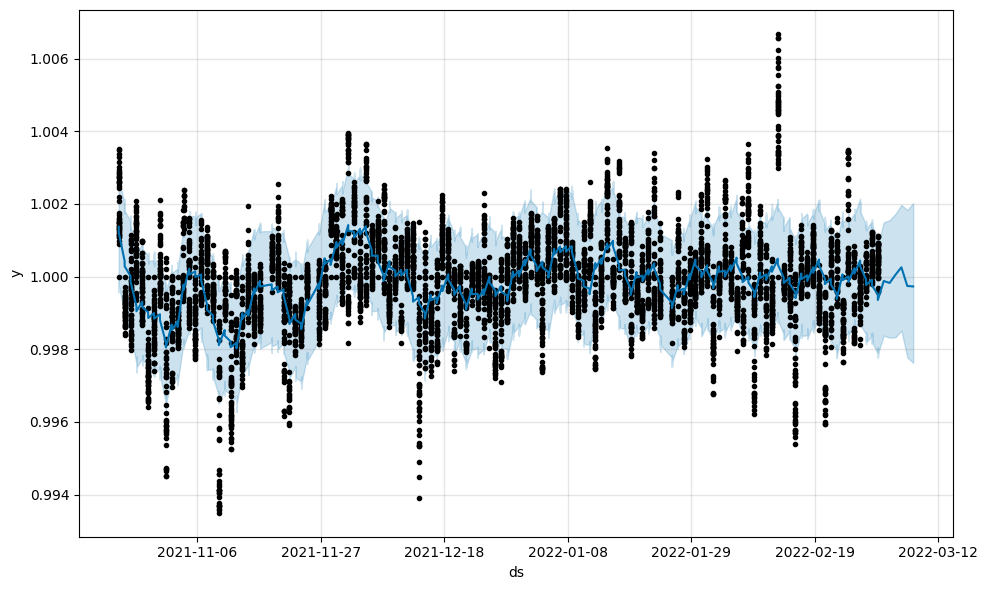

In [22]:
from fbprophet import Prophet
import datetime
np.float = float

start_date = datetime.datetime(2021, 1, 1, 16, 50, 0)
stock = 0
df = df_train3[df_train3["stock_id"] == stock]
# add time elapsed df[date_id] days  
df["ds"] =  start_date + pd.to_timedelta(df["date_id"], unit='D') + pd.to_timedelta(df["seconds_in_bucket"], unit='S')
df = df[["ds", "wap"]]
df.columns = ["ds", "y"]
df["y"] = df["y"].astype(float)

# print row with max date_id
print(df[df["ds"] == df["ds"].max()])

#print df types
print(df.dtypes)

model = Prophet()
model.fit(df)

#future = model.make_future_dataframe(periods=6, freq='s')

# Determine the last timestamp in your data
last_timestamp = df['ds'].max()

# Generate future timestamps at 10-second intervals
# For example, generating timestamps for the next 5 minutes (300 seconds / 10-second interval = 30 periods)
future_timestamps = [datetime.datetime(last_timestamp.year, last_timestamp.month, last_timestamp.day + 1, 16, 50, 0) + pd.Timedelta(seconds=10)*i for i in range(0, 6)]

# Create a future DataFrame
future_df = pd.DataFrame({'ds': future_timestamps})

# Use this DataFrame to predict future values
forecast = model.predict(future_df)

forecast = model.predict(future)
fig1 = model.plot(forecast)

forecast.tail(6)